# Single cell case

Code to produce figures 2(c) - (e) of the main text. 

# Import packages 

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
from scipy.special import xlogy

# Model 

Define the standard values of the parameters

In [6]:
# Normalized concentration of molecules c_v = [FGF]/[FGF]_0, e_v = [eph]/[eph]_0
c_v =  5  
e_v =  5 

# Total number of molecules in each cell
Rt_v =  2000 # Total number of FGF receptors
Qt_v =  2000 # Total number of ephrin receptors
Erkt_v= 4000 # Total number of ERK molecules

# Values of the reaction rates  
Kd =  60 
kd_plus_v = 0.1  
kd_minus_v = Kd*kd_plus_v
 
Ke =  40 
ke_plus_v = 0.1 
ke_minus_v = Ke*ke_plus_v

k_v =  0.2
Vs_v=  1*k_v 
Vrg_v = 0.4*k_v

# Values of half saturation constants
Ks_v =  200  
Krg_v =  200 

# Parameters input distribution (Lognormal distr centered around mu_c, with variance sigma_F^2)
mu_c = 5 
sigma_F =1

# Cell surface
Scell_v = 6000 # Total cell surface (um^2)
S1max = Scell_v/2 # Maximum surface exposed to FGF
S1_v = 0.5*Scell_v # Surface exposed to FGF (um^2)

# The surface exposed to FGF (S1) is related to the surface exposed to ephrin (S2) through:
# S2 = A*S1+B*Scell  (Eq.5) 
A = -1.1265
B = 0.9092

Function to compute the number of active ERK molecules ($E^*$) (Eq. 1-3)

In [8]:
# Function to compute ERK as a function of the input 
def ERK(var, args, varS1=True): 

    if varS1==True: 
        S1= var 
        kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    else: 
        c= var 
        kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)
        
    return np.float32(Erk_ss) 

Function to compute the noise in the number of active ERK molecules ($\sigma_e$) (Eq. 22 - 28)

In [10]:
# Function to compute the noise as a function of the input 
def sigma(var, args, varS1=True):
    
    if varS1==True: 
        S1= var 
        kd_plus, kd_minus, ke_plus, ke_minus, c, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args
    else: 
        c= var 
        kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    Tau_c = (kd_plus*c+kd_minus)**(-1)
    Tau_e = (ke_plus*e+ke_minus)**(-1)
    Tau_E = (k + Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg) )**(-1)

    Gamma_R = 2*Vs*Rb_ss*Ks**2/(Rb_ss**2+Ks**2)**2*(Erkt-Erk_ss)
    Gamma_Q = Vrg*Krg/(Qb_ss+Krg)**2*Erk_ss

    n_ss = c*kd_plus/(kd_minus + c*kd_plus)
    m_ss = e*ke_plus/(ke_minus + e*ke_plus)

    A_R = 2/Tau_c*Rt*S1/Scell*n_ss*(1-n_ss)
    A_Q = 2/Tau_e*Qt*S2/Scell*m_ss*(1-m_ss)
    A_E = 2*Vs*Rb_ss**2/(Rb_ss**2+Ks**2)*(Erkt-Erk_ss)

    sigma_R = Gamma_R**2*A_R/2*(Tau_c-Tau_E)/(Tau_E**(-2)-Tau_c**(-2))
    sigma_Q = Gamma_Q**2*A_Q/2*(Tau_e-Tau_E)/(Tau_E**(-2)-Tau_e**(-2))
    sigma_E = A_E/2*Tau_E

    sigma2 = sigma_R + sigma_Q + sigma_E
        
    return np.float32(np.sqrt(sigma2))


# Information transmission

Function to compute the input probability distribution $P(c)$ (Eq. 7)

In [13]:
def Pf_Lognorm(var, mu_c, sigma_F): 
    mu1 = np.log(mu_c**2/np.sqrt(mu_c**2+sigma_F**2))
    sig = np.sqrt(np.log(1+sigma_F**2/mu_c**2))
    distr = 1/(2*np.pi*sig**2*var**2)**(1/2)*np.exp(-1/2*((np.log(var)-mu1)/sig)**2) 
    return distr

Function to compute the condistional probability distribution $P(E^*|c) = \mathcal{G}(E^*, \bar{E}^*, \sigma_e^2)$ (Eq. 9)

In [15]:
def P_ERKF(var, ERK_temp, args):
    
    # Gaussian centered around ERK_v, with std = sigma_v 
    ERK_v = ERK(var, args= args, varS1=False)
    sigma_v = sigma(var, args=args, varS1=False)

    distr = 1/(2*np.pi*sigma_v**2)**(1/2)*np.exp(-1/2*((ERK_temp - ERK_v)/sigma_v)**2)   
    
    # Return the normalized distribution    
    return distr/np.trapz(distr,ERK_temp)

Function to compute the output probability distribution $P(E^*) = \int P(E^*|c) P(c) dc$ (Eq. 10)

In [17]:
# Define the distribution of the outputs P(ERK) = int P(ERK/FGF)P(FGF) dFGF
def PERK(ERK_temp, c_temp, Pc, args):
    integrand = []
    
    for i in range(len(c_temp)): 
        Perkf_temp = P_ERKF(c_temp[i], ERK_temp, args=args)
        integrand.append(Perkf_temp*Pc[i])
    
    # Return the output distribution
    return np.trapz(integrand, c_temp, axis=0)

Function to compute information $I(c;E^*) =- \int P(E^*)\log_2(P(E^*)) dE^* + \int dc P(c) \int P(E^*|c)\log_2(P(E^*|c)) dE^* $ (Eq. 6)

In [19]:
def I(c_temp, ERK_temp, Pin, Pout, args):

    # Compute int P(ERK)log2(P(ERK)) dERK
    I1 = np.trapz( xlogy(Pout, Pout)/np.log(2), ERK_temp) 
    
    # Compute int P(ERK|FGF)log2(P(ERK|FGF)) dErk
    sigm =  sigma(c_temp, args=args, varS1=False)
    I2= - 1/2*np.log2(2*np.pi*np.exp(1)*sigm**2) # - (Entropy of Gaussian distribution)
    
    # Compute int P(c)*I2
    I3 = np.trapz(I2*np.float32(Pin), c_temp)
    
    # Return the information 
    return - I1 + I3

# Figures

## Fig. 2(c)

Compute information as a function of $S_1$ (in the presence and in the absence of ephrin)

In [22]:
# Input distribution
mu = 40
sigma_F = 1

cmin = np.max((mu-5*sigma_F, 1e-2))
cmax = mu + 5*sigma_F

c_temp = np.linspace(cmin, cmax, 50)
Pin = Pf_Lognorm(c_temp, sigma_F= sigma_F, mu_c=mu)

# Parameters
S1_temp = np.linspace(S1max/20, S1max)

In [23]:
# In the presence of ephrin

arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

# Update the parameters with the different values of S1_temp
args_temp = [arg[0:4]+[S1_temp[i]]+arg[5:] for i in range(len(S1_temp))]

# Compute the output distribution for different values of S1 
ERK_S1 = []
Pout=[]

for i in range(len(S1_temp)): 
    ERKmaxv = ERK(cmax, args=args_temp[i], varS1=False)
    ERKminv = ERK(cmin, args=args_temp[i], varS1=False)
    ERKmin = np.max((ERKminv - ERKminv, 1e-4))
    
    ERK_S1_temp = np.linspace(ERKmin, ERKmaxv+ERKmaxv, 200)
    ERK_S1.append(ERK_S1_temp)
    
    Pout.append(PERK(ERK_S1_temp, c_temp, Pc=Pin, args=args_temp[i]))
   
# Compute information for different values of S1
Info_S1=[]

for i in range(len(S1_temp)): 
    Info_S1.append(I(c_temp, ERK_temp= ERK_S1[i], Pin=Pin, Pout= Pout[i], args=args_temp[i]))

In [24]:
# In the absence of ephrin

arg_noE = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_v, 1e-10, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

args_temp_noE = [arg_noE[0:4]+[S1_temp[i]]+arg_noE[5:] for i in range(len(S1_temp))]

# Compute the output distribution for different values of S1 
ERK_S1_noE = []
Pout_noEph = []

for i in range(len(S1_temp)): 

    ERKmaxv_noE = ERK(cmax, args=args_temp_noE[i], varS1=False)
    ERKminv_noE = ERK(cmin, args=args_temp_noE[i], varS1=False)
    ERKmin_noE = np.max((ERKminv_noE - ERKminv_noE, 1e-4))
    
    ERK_S1_temp_noE = np.linspace(ERKmin_noE, ERKmaxv_noE+ERKmaxv_noE, 200)
    ERK_S1_noE.append(ERK_S1_temp_noE)
    
    Pout_noEph.append(PERK(ERK_S1_temp_noE, c_temp, Pc=Pin, args=args_temp_noE[i]))

# Compute information for different values of S1
Info_S1_noEph=[]

for i in range(len(S1_temp)): 
    Info_S1_noEph.append(I(c_temp, ERK_temp= ERK_S1_noE[i], Pin=Pin, Pout= Pout_noEph[i], args=args_temp_noE[i]))

In [25]:
# Compute ERK as a function of S1
c_v = 40

args_c = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, c_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]
Erk_S1 = ERK(S1_temp, args=args_c, varS1=True)

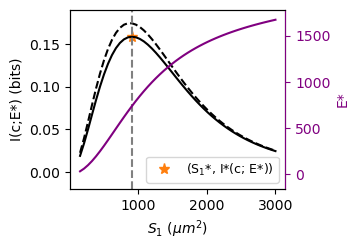

In [26]:
# Figure 

color1 = 'k'
color2 = 'purple'

fig, ax1 = plt.subplots(figsize=(3.7,2.6)) 

ax1.plot(S1_temp[Info_S1 ==np.max(Info_S1)], np.max(Info_S1), marker='*', color='tab:orange', \
         linestyle='none' , markersize=8, label='(S$_1$*, I*(c; E*))')
ax1.plot(S1_temp, np.array(Info_S1), '-',color='k', linewidth=1.5)
ax1.plot(S1_temp, Info_S1_noEph, '--',color='k', linewidth=1.5)

ax1.set_xlabel('$S_1$ $(\\mu m^2)$', fontsize=10)
ax1.set_ylabel('I(c;E*) (bits)', fontsize=10, color=color1) 
ax1.tick_params(axis='y', labelcolor=color2)
ax1.spines['left'].set_color(color1)
ax1.tick_params(axis='y', colors=color1) 
ax1.set_ylim([-0.02, 0.19])

ax1.axvline(x=S1_temp[Info_S1 ==np.max(Info_S1)],color='grey', linestyle= '--')
ax1.legend(fontsize=9, loc = 'lower right')

ax2 = ax1.twinx()  

ax2.plot(S1_temp, Erk_S1, '-', color=color2, linewidth=1.5)

ax2.set_ylabel('E*', fontsize=10, color=color2)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-160, 1780])
ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2)

fig.tight_layout()  
plt.savefig('Fig_2c.pdf')
plt.show()

## Fig. 2(d)

## Experimental data 

In [29]:
S1_temp = np.linspace(S1max/20, S1max)

# Compute dEdc(c) and sigma(c) @ c=40 for different values of S1
c_v = 40
c_temp = np.linspace(c_v-0.1, c_v + 0.1, 20)

dEdc_cv = []
sigma_temp_cv = []

for i in range(len(S1_temp)):
    arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_temp[i], e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

    Erk_temp = ERK(c_temp, args=arg, varS1=False)
    dEdc_cv.append(np.gradient(Erk_temp, c_temp)[len(c_temp)//2])
    sigma_temp_cv.append(sigma(c_v, args=arg, varS1=False))


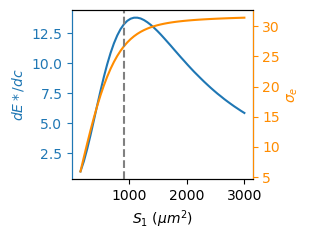

In [30]:
fig, ax1 = plt.subplots(figsize=(3.2,2.5))

color1 = 'tab:blue'
color2 = 'darkorange'

ax1.plot(S1_temp, dEdc_cv, color=color1, linewidth=1.5)

ax1.set_xlabel('$S_1$ ($\\mu m^2$)', fontsize=10)
ax1.set_ylabel('$dE*/dc$', fontsize=10, color=color1) 
ax1.tick_params(axis='y', labelcolor=color2)
ax1.spines['left'].set_color(color1)
ax1.tick_params(axis='y', colors=color1) 

ax2 = ax1.twinx() 

ax2.plot(S1_temp, sigma_temp_cv, '-', color=color2, linewidth=1.5)

ax2.set_ylabel('$\\sigma_e$', fontsize=10, color=color2) 
ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2)
ax2.axvline(x=910, color='grey', linestyle= '--')

fig.tight_layout() 
plt.savefig('Fig_2d.pdf')
plt.show()

## Fig. 2(e)

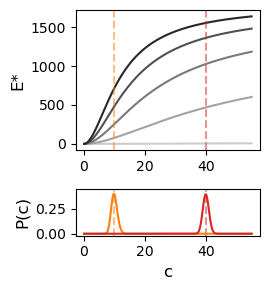

In [32]:
# Figure to explain intuitively the shape of the curve above as a function of S1

S1_temp = np.linspace(0.01, 0.5, 6)*Scell_v
color = cm.binary(np.linspace(0.2, 1, len(S1_temp)))

norm = matplotlib.colors.Normalize(vmin=np.min(S1_temp/Scell_v), vmax=np.max(S1_temp/Scell_v)) 
sm = matplotlib.cm.ScalarMappable(cmap='binary', norm=norm)    

c_temp = np.linspace(0.1, 55, 200)
Pc1 = Pf_Lognorm(c_temp, 10, 1)
Pc2 = Pf_Lognorm(c_temp, 40, 1)

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(2.8,3))

for i in range(len(S1_temp)-1): 
    arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_temp[i], e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v]

    Erk_temp = ERK(c_temp, args=arg, varS1=False)
    sigma_temp = sigma(c_temp, args=arg, varS1=False)

    ax1.plot(c_temp, Erk_temp,label=f'S1 = {np.round(S1_temp[i],1)}', color=color[i])
    
ax1.axvline(x=10, color='tab:orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.axvline(x=10, color='tab:orange', linestyle='--', linewidth=1.5, alpha=0.5)

ax1.axvline(x=40, color='tab:red', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.axvline(x=40, color='tab:red', linestyle='--', linewidth=1.5, alpha=0.5)

#cb = plt.colorbar(sm, aspect=20, orientation='vertical', ax=ax1, fraction=0.036, pad=0.08)

ax2.plot(c_temp, Pc1, color='tab:orange')
ax2.plot(c_temp, Pc2, color='tab:red')
ax1.set_ylabel('E*', fontsize=12)
ax2.set_ylabel('P(c)', fontsize=12)
ax2.set_xlabel('c', fontsize=12)

ax2.set_ylim([-0.02, 0.45])

plt.tight_layout()
plt.savefig('Fig_2e.pdf')
plt.show()

## Fig. 2(f)

In [34]:
# Define the vector S1_temp 
S1_temp = np.round(np.linspace(S1max/10, S1max, 100),2)
   
# Define the values of the paramenters
arg = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_v, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, Scell_v] # In the presence of ephrin
arg_noE = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_v, 1e-10, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, 1e-8,\
       Rt_v, Erkt_v, Scell_v] # In the absence of ephrin

# Update the paramters with the possible values of S1
args_temp = [arg[0:4]+[S1_temp[i]]+arg[5:] for i in range(len(S1_temp))]
args_temp_noE = [arg_noE[0:4]+[S1_temp[i]]+arg_noE[5:] for i in range(len(S1_temp))]

# Vector with the values of mu_c 
mu_temp = np.linspace(1, 40, 60)

Info_S1_cv = []
Info_S1_cv_noE = []

for k in range(len(mu_temp)): 
    print(k)
    cmin = np.max((mu_temp[k]-5*sigma_F, 1e-3))
    cmax = mu_temp[k]+5*sigma_F
    c_temp = np.linspace(cmin, cmax, 100)
    P_in = Pf_Lognorm(c_temp, sigma_F=sigma_F, mu_c=mu_temp[k])
    
    # Define the vectors ERK_temp
    ERK_S1 = []
    ERK_S1_noE = []
    for i in range(len(S1_temp)): 
    
        # With ephrin 
        ERKvmin = ERK(cmin, args=args_temp[i], varS1=False)
        ERKvmax = ERK(cmax, args=args_temp[i], varS1=False)

        ERKvmin = np.max((1e-4, ERKvmin- ERKvmin/4))
        ERKvmax = ERKvmax+ERKvmax/4

        ERK_temp = np.linspace(ERKvmin, ERKvmax, 100)

        ERK_S1.append(ERK_temp)
        
        # Without ephrin
        ERKvmin_noE = ERK(cmin, args=args_temp_noE[i], varS1=False)
        ERKvmax_noE = ERK(cmax, args=args_temp_noE[i], varS1=False)
        
        ERKvmin_noE = np.max((1e-4, ERKvmin_noE- ERKvmin_noE/4))
        ERKvmax_noE = ERKvmax_noE+ERKvmax_noE/4
        
        ERK_temp_noE = np.linspace(ERKvmin_noE, ERKvmax_noE, 100)
        
        ERK_S1_noE.append(ERK_temp_noE)
        
    # Compute the output distribution 
    Pout = [] 
    Pout_noE = [] 
    
    for i in range(len(S1_temp)):
        Pout.append(PERK(ERK_S1[i], c_temp, Pc=P_in, args=args_temp[i]))
        Pout_noE.append(PERK(ERK_S1_noE[i], c_temp, Pc=P_in, args=args_temp_noE[i]))
    
    # Compute information for different mu_c
    
    Info_S1_temp_cv = []
    Info_S1_temp_cv_noE = []
    
    for i in range(len(S1_temp)):
        Info_S1_temp_cv.append(I(c_temp, ERK_temp= ERK_S1[i], Pin=P_in, Pout= Pout[i], args=args_temp[i]))
        Info_S1_temp_cv_noE.append(I(c_temp, ERK_temp= ERK_S1_noE[i], Pin=P_in, Pout= Pout_noE[i], args=args_temp_noE[i]))
    
    
    Info_S1_cv.append(Info_S1_temp_cv)
    Info_S1_cv_noE.append(Info_S1_temp_cv_noE)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [35]:
# Compute Imax as a function of mu_c 
# and the optimal surface S1* as a function of mu_c
maxI_cv = []
opt_S1 = []

for i in range(len(mu_temp)): 
    maxI_cv.append(np.max(Info_S1_cv[i]))
    opt_S1.append(S1_temp[Info_S1_cv[i]==np.max(Info_S1_cv[i])])
    
maxI_cv_noE = []
opt_S1_noE = []

for i in range(len(mu_temp)): 
    maxI_cv_noE.append(np.max(Info_S1_cv_noE[i]))
    opt_S1_noE.append(S1_temp[Info_S1_cv_noE[i]==np.max(Info_S1_cv_noE[i])])

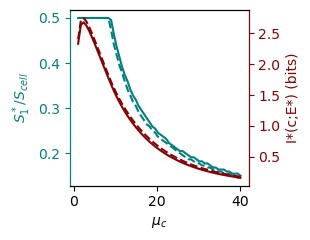

In [36]:
# Figure
color1 = 'teal'
color2 = 'darkred'

fig, ax1 = plt.subplots(figsize=(3.2,2.5))

ax1.plot(mu_temp, np.array(opt_S1)/Scell_v, color=color1, linewidth=1.5)
ax1.plot(mu_temp, np.array(opt_S1_noE)/Scell_v, '--',color=color1, linewidth=1.5, label='Without ephrin')

ax1.set_xlabel('$\\mu_c$', fontsize=10)
ax1.set_ylabel('$S_{1}^*$/$S_{cell}$', fontsize=10, color=color1) 
ax1.tick_params(axis='y', labelcolor=color2)
ax1.spines['left'].set_color(color1)
ax1.tick_params(axis='y', colors=color1) 

ax2 = ax1.twinx() 
ax2.plot(mu_temp, maxI_cv, '-', color=color2, linewidth=1.5, label='With ephrin')
ax2.plot(mu_temp, maxI_cv_noE, '--', color=color2, linewidth=1.5, label='Without ephrin')

ax2.set_ylabel('I*(c;E*) (bits)', fontsize=10, color=color2)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2)

fig.tight_layout()
plt.savefig('Fig_2f.pdf')
plt.show()